<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

<font size="6"> Notebook 2 : Modèles non supervisés </font>

**Librairies**

In [1]:
# Data analyse
import pandas as pd
import numpy as np
from pprint import pprint
from operator import itemgetter

In [2]:
# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [3]:
# Modèles
import gensim
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from sklearn.decomposition import NMF

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

# Evaluation
from gensim.models import CoherenceModel

C:\Users\EliseAndro\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\EliseAndro\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


**Chargement des données traités dans le Notebook 1**

In [8]:
df = pd.read_pickle("./pkl_objects/preprocess_data.pkl")

In [9]:
df

,content,preprocess_content,word_count,version-control,forms,sql,syntax,asp.net-mvc,numpy,http,...,objective-c,exception,sorting,matplotlib,c,android,ios,linq,swift,java-8
0,is there any way to tinker with the iphone sdk...,"[way, machine, plan, version, way, think, run,...",70,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,i have this gigantic ugly string j transaction...,"[gigantic, ugly, string, transaction, start, p...",120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[work, autolayout, constraint, find, constrain...",199,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,i m learning objective c and keep bumping into...,"[learn, objective, keep, bump, symbol, use, di...",48,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[simple, way, pretty, standard, unix, environm...",113,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,recently i upgraded the version of django fram...,"[recently_upgrade, version, django, framework,...",331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44991,how can i reject a promise that returned by an...,"[reject, promise, return, async_await, functio...",88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44992,i have entities that are related as one to man...,"[entity, relate, manypublic, class, restaurant...",296,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44993,problemi want to return a file in my asp net w...,"[want, return, file, web, api, controller, app...",90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Latent Dirichlet Allocation

Principes du LDA : 

## Create the dictionary and Corpus needed for topic modeling

Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(df['preprocess_content'])
# Create Corpus
texts = df['preprocess_content']
# Term Document Frequancy
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2)]


In [11]:
#Exemple de mot du dictionnaire
id2word[0]

'develop'

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('develop', 1),
  ('development', 1),
  ('image', 1),
  ('iphone', 1),
  ('legal', 1),
  ('machine', 2),
  ('plan', 1),
  ('run', 2),
  ('server', 1),
  ('sure', 1),
  ('think', 1),
  ('use', 1),
  ('version', 1),
  ('vmware', 1),
  ('way', 2),
  ('window', 2)]]

## Find the optimal number of topics for LDA?

In [13]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics= num_topics, 
                                                random_state=100, 
                                                update_every=1,
                                                chunksize=200,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=df['preprocess_content'], 
                                                        start=9, 
                                                        limit=33, 
                                                        step=3)

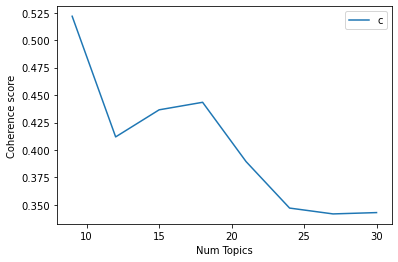

In [15]:
# Show graph
limit=33; start=9; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [16]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 9  has Coherence Value of 0.5219
Num Topics = 12  has Coherence Value of 0.4119
Num Topics = 15  has Coherence Value of 0.4366
Num Topics = 18  has Coherence Value of 0.4434
Num Topics = 21  has Coherence Value of 0.3894
Num Topics = 24  has Coherence Value of 0.3471
Num Topics = 27  has Coherence Value of 0.3417
Num Topics = 30  has Coherence Value of 0.3429


In [17]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(18,
  '0.188*"script" + 0.148*"php" + 0.089*"interface" + 0.071*"extension" + '
  '0.051*"spring" + 0.047*"operator" + 0.041*"directive" + 0.031*"external" + '
  '0.028*"filename" + 0.024*"network"'),
 (6,
  '0.133*"component" + 0.090*"react" + 0.089*"database" + 0.087*"state" + '
  '0.081*"store" + 0.065*"render" + 0.055*"connect" + 0.044*"prop" + '
  '0.039*"mysql" + 0.028*"record"'),
 (15,
  '0.200*"element" + 0.079*"expect" + 0.074*"send" + 0.058*"syntax" + '
  '0.055*"release" + 0.051*"break" + 0.038*"double" + 0.034*"nil" + '
  '0.032*"strong" + 0.026*"assign"'),
 (9,
  '0.265*"time" + 0.063*"studio" + 0.056*"next" + 0.051*"implementation" + '
  '0.046*"language" + 0.045*"fast" + 0.030*"equivalent" + 0.026*"basic" + '
  '0.026*"master" + 0.025*"namespace"'),
 (17,
  '0.122*"variable" + 0.110*"mean" + 0.102*"css" + 0.078*"width" + '
  '0.076*"height" + 0.047*"apply" + 0.037*"cell" + 0.034*"declare" + '
  '0.030*"div" + 0.025*"guess"'),
 (16,
  '0.176*"array" + 0.128*"json" + 0.1

**Compute Model Perplexity and Coherence Score**

In [18]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=df['preprocess_content'], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.768408306995678

Coherence Score:  0.34172822355384697


## Visualize the topics-keywords

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14     0.343266  0.100252       1        1  27.324680
19     0.204897 -0.299193       2        1   9.211716
11     0.036270 -0.101558       3        1   4.480825
3      0.047327  0.039695       4        1   3.789259
21     0.153957  0.062735       5        1   3.609363
8     -0.023792 -0.030362       6        1   3.482767
20     0.048227  0.046575       7        1   3.368605
24     0.017778 -0.008704       8        1   3.278440
26     0.056514 -0.094853       9        1   3.251619
5      0.105180  0.214282      10        1   3.136366
1     -0.030318 -0.010609      11        1   2.912654
13     0.039061  0.188070      12        1   2.841510
4     -0.042879 -0.014018      13        1   2.734960
22    -0.050435  0.000541      14        1   2.589654
7     -0.000961 -0.162845      15        1   2.351743
12    -0.057440  0.028271      16        1   2.335872
25    -0.053738  0.007379      17        1   2.302992
23    -0.018712 -0.098395      18        1   2.190826
0     -0.064873  0.004658      19        1   2.162103
2     -0.058696  0.011178      20        1   1.965456
16    -0.047521  0.064856      21        1   1.845436
10    -0.084032  0.008220      22        1   1.817469
17    -0.097180  0.010507      23        1   1.621216
9     -0.094822  0.011439      24        1   1.546704
6     -0.094358  0.010035      25        1   1.391293
15    -0.114060  0.003471      26        1   1.378391
18    -0.118661  0.008376      27        1   1.078081, topic_info=               Term          Freq         Total Category  logprob  loglift
68             file  24296.000000  24296.000000  Default  30.0000  30.0000
212           class  19286.000000  19286.000000  Default  29.0000  29.0000
313           error  19807.000000  19807.000000  Default  28.0000  28.0000
46           string  18411.000000  18411.000000  Default  27.0000  27.0000
11              use  47816.000000  47816.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
652         bracket     87.159089     88.246253  Topic27  -5.5188   4.5176
1187  event_handler     80.948576     82.035740  Topic27  -5.5928   4.5166
1418        closing     46.916519     48.003683  Topic27  -6.1382   4.5071
1196       generics     31.919366     33.006530  Topic27  -6.5234   4.4965
607       implement     82.957721   2201.198297  Topic27  -5.5682   1.2516

[912 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1049     23  0.989637  absolutely
1706     26  0.998150    abstract
1406     14  0.997994      accord
1041      9  0.999479      action
832      17  0.998398      active
...     ...       ...         ...
1058     23  0.998847     wrapper
155       1  0.999831       write
352       4  0.263418         xml
352      10  0.735794         xml
1138     18  0.998841        year

[877 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 20, 12, 4, 22, 9, 21, 25, 27, 6, 2, 14, 5, 23, 8, 13, 26, 24, 1, 3, 17, 11, 18, 10, 7, 16, 19])

**Word Cloud of Top N words in each topic**

IndexError: list index out of range

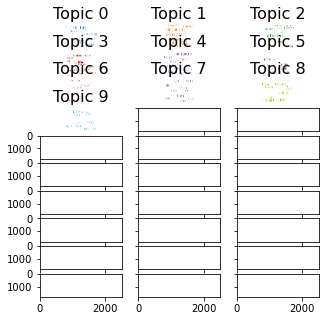

In [20]:
#Wordcloud of Top N words in each topic
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(10, 3, figsize=(5,5), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['preprocess_content'])

In [ ]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                    grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                   axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf

**Topic distribution across documents**

In [ ]:
df_dominant_topics = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Documents')

df_dominant_topics['Perc_Documents'] = (df_dominant_topics['Num_Documents'])/(df_dominant_topics['Num_Documents'].sum())

df_dominant_topics

# Non-Negative Matrix Factorization

Principes de la NMF : 

In [ ]:
def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


In [ ]:
# Use Gensim's NMF to get the best num of topics via coherence score
texts = df['preprocess_content']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(9, 33, 3))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

In [ ]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

In [ ]:
# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
texts

In [ ]:
# Now use the number of topics with the highest coherence score to run the sklearn nmf model

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

In [ ]:
# Use the top words for each cluster by tfidf weight to create 'topics'

# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df

In [ ]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

# Prédiction à partir d'un modèle non supervisé

In [ ]:
df.head()

## Split en train et test test

In [ ]:
# 75% random du dataset pour le train
dftrain = df.sample(frac = 0.75)

# 25% restant pour la prédiction sur data inconnue
dftest = df.drop(dftrain.index).reset_index().drop(columns = 'index')

dftrain = dftrain.reset_index().drop(columns = 'index')

In [ ]:
dftrain

In [ ]:
dftest.head()

## Entrainement du modèle

In [ ]:
# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join)

tfidf = tfidf_vectorizer.fit_transform(dftrain['preprocess_content'])

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42).fit(tfidf)

nmf

## Prédiction sur le test set (données inconnue du modèle)

In [ ]:
# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(dftest['preprocess_content'])
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
dftest['topic_num'] = predicted_topics

dftest

In [ ]:
# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(dftrain['preprocess_content']))

n_top_words = 10

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df

In [ ]:
# Join with the original df to get the topic summary
dfpred = pd.merge(dftest, topic_df, on='topic_num', how='left')

dfpred

# Extraire des tags à partir des résultats précédents

In [ ]:
test = dfpred.loc[dfpred['topic_num']==1]

In [ ]:
test.iloc[:,3:-2]

In [ ]:
# Nbre d'occurence des tags
sum_column1 = test.iloc[:,3:-2].sum(axis=0)
print (sum_column1.sort_values()[-5:])